
# Convolutional Neural Networks for Object Localization

In this notebook we will learn how to implement a convolutional neural network (CNN) regressor to localize objects of the FashionMNIST dataset. We will use the Pytorch library for the implementation, compilation and training of the model.

The input to our model is a $64 \times 64$ image with a FashionMNIST object at any location, and the output of the model are four real numbers that define a bounding box (x, y, width, and height) around the object.

*   Object detection = tienes que decir dónde está y qué es la cosa. 
*   Object localization = tienes que decir dónde está y qué es la cosa. Sabemos cuántos objectos hay por imagen (más fácil).




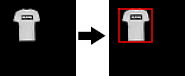

### Import necessary modules

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

from torchsummary import summary

print('Check GPU runtime type... ')
use_cuda = torch.cuda.is_available()
if not use_cuda:
  device = "cpu"
  print('Change Runtype Type in top menu for GPU acceleration')
else:
  device = "cuda"
  print('OK!')

Check GPU runtime type... 
OK!


## Create a custom dataset

First of all we need a custom dataset class to create our training/test samples. This class creates synthetic images by placing FashionMNIST objects (wich have a size $28 \times 28$) at random locations of a black $64 \times 64$ canvas image.

In [11]:
class FashionMNISTlocalizationDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True)

    def __len__(self): #número de muestras que tiene nuestro dataset
        return self.fashionMnist.data.shape[0]

    def __getitem__(self, idx): #define el comportamiento de devolver una muestra de nuestro dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize) #crear imagen negra de 64x64
        image_width, image_height = self.imgsize
                
        # Get one Fashion-MNIST object, resize it randomly, and copy it into
        # a random location of the black image
        object_img = self.fashionMnist.data[idx,:,:] #seleccionar objeto que toque dado el índice

        object_width  = object_height = np.random.randint(19,47)

        object_img = resize(object_img, (object_height, object_width))

        x_offset = np.random.randint(0,image_width-object_width)
        y_offset = np.random.randint(0,image_height-object_height)

        image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
        
        image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform: #convertir imagen en tensor
            image = self.transform(image)

        # normalize the target values (bounding box coordinates) so they are real numbers from 0. to 1.
        bbox = np.array([x_offset / image_width, y_offset / image_height, 
                         object_width / image_width, object_height / image_height], dtype=np.float32)
            
        sample = {'image': image, 'bbox': bbox}

        return sample

Now we can create the necessary Dataset and DataLoader objects as follows.

In [12]:
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform) #train
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform) #validation

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)

### Visualize some generated samples

0 torch.Size([1, 64, 64]) (4,)
1 torch.Size([1, 64, 64]) (4,)
2 torch.Size([1, 64, 64]) (4,)
3 torch.Size([1, 64, 64]) (4,)


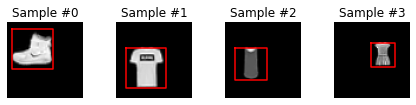

In [13]:
def show_bbox(image, bbox, pred=None):
    """Show image with bbox"""
    image = image.squeeze()
    plt.imshow(image, cmap='gray')

    # plot the ground truth bounding box
    imgsize = image.shape
    bbox *= [imgsize[1],imgsize[0],imgsize[0],imgsize[1]]
    plt.plot([bbox[0],bbox[0]+bbox[2],bbox[0]+bbox[2],bbox[0],bbox[0]],
             [bbox[1],bbox[1],bbox[1]+bbox[3],bbox[1]+bbox[3],bbox[1]], c='r')

    if pred is not None: 
        # plot the predicted bounding box (if provided)
        pred *= [imgsize[1],imgsize[0],imgsize[0],imgsize[1]]
        plt.plot([pred[0],pred[0]+pred[2],pred[0]+pred[2],pred[0],pred[0]],
                 [pred[1],pred[1],pred[1]+pred[3],pred[1]+pred[3],pred[1]], c='b')
    
    
 
fig = plt.figure()
for i in range(len(dataset1)):
    sample = dataset1[i]
    print(i, sample['image'].shape, sample['bbox'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bbox(**sample)

    if i == 3:
        plt.show()
        break

In [14]:
# check the size of the dataset
print("Size of training data: {}".format(len(dataset1)))
print("Size of test data: {}".format(len(dataset2)))

Size of training data: 60000
Size of test data: 10000


We have 60,000 images for training and 10,000 for testing. The image size is $64 \times 64$ pixels and they have only one channel (greyscale images).

## Create the CNN regression model

We will use a simple CNN model with four convolutional layers, one pooling layer, and two fully connected layers. 

Notice that the output layer has four neurons with a `sigmoid` activation, so our model produces at its outputs four real numbers (x, y, width, and height).

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1), #quedarnos solo con los channels (cargarnos las dimensiones espaciales)
          nn.Flatten(),
          )
        
        self.bbox = nn.Sequential(nn.Linear(32,4), nn.Sigmoid()) #nuestro regresor tendrá 32 features y 4 coordenadas (x, y, width, height)
        #la Sigmoide sirve para facilitar el training (ya que las coordenadas del bb están normalizadas)
        
    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox(features)
        return bbox

summary(Net(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 4]             132
          Sigmoid-12                    [-1, 4]               0
Total params: 15,396
Trainable params: 15,396
Non-trainable params: 0
---------------------------------

### Define the training method

For training our CNN regression model we will use the L1 loss, which takes the mean element-wise absolute value difference.

See <a href="https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss">`torch.nn.L1Loss`</a> for details.

In [16]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image'] 
        target = sample_batched['bbox']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.l1_loss(output, target) 
        loss_values.append(loss)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None: #siempre después del omtimizer.step()
            scheduler.step()
    return loss_values

### Train the model

We will train the model with the [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) and the [`OneCycleLR`](https://pytorch.org/docs/stable/optim.html?highlight=onecyclelr#torch.optim.lr_scheduler.OneCycleLR) learning rate scheduler.

In [17]:
model = Net().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader)) #modifica el learning rate a lo largo del training de una forma u otra

log_interval = 100 # how many batches to wait before logging training status

loss_history = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch, scheduler)
    loss_history += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.188221
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.106205
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.096817
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.073709
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.070295
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.050708
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.051893
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.040591
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.039919
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.041472
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.036230
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.030269
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.034742
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.029751
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.029851
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.026735
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.021540
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.023879
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.025499
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.021067
Train Epoch:

### Plot the loss over time

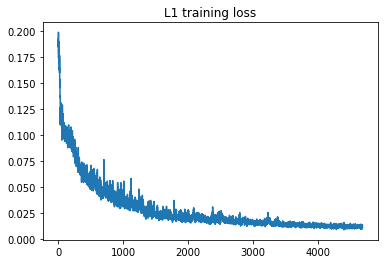

In [18]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.title('L1 training loss')
plt.show()

## Evaluate the model

Finally, we can use the trained model to predict a bounding box for any given image. Let's see how to make predictions for the first four images of the test set.

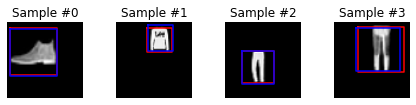

In [ ]:
model.eval()

fig = plt.figure()
for i in range(len(dataset2)):
    sample = dataset2[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    # predict the bounding box for a given image
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        
    sample['pred'] = output[0].cpu().numpy()
    show_bbox(**sample)

    if i == 3:
        plt.show()
        break

We appreciate that the predicted bounding boxes (blue) are usually good aproximations of the ground truth (red).

In order to measure whether the results are correct or not in the entire test set we need to implement a performance measure based on the Intersection over Union (IoU) of the ground truth and predicted bounding boxes.

<table>
<tr>
<td><img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_stop_sign.jpg" width=50%></td>
<td><img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png" width=50%></td>
</tr>
<tr>
<td colspan=2><div style="font-size:3">Images from: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/</div></td>
</tr>
</table>


In [ ]:
def IoU(pred, target, iou_threshold = 0.7): #si la detección es mayor que un 70%, la damos por buena
    # determine the coordinates of the intersection rectangle
    x_left = np.maximum(pred[:,0], target[:,0])
    y_top = np.maximum(pred[:,1], target[:,1])
    x_right = np.minimum(pred[:,0]+pred[:,2], target[:,0]+target[:,2])
    y_bottom = np.minimum(pred[:,1]+pred[:,3], target[:,1]+target[:,3])
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the areas of the union
    pred_area = pred[:,2] * pred[:,3]
    target_area =  target[:,2] *  target[:,3]
    
    union_area = pred_area + target_area - intersection_area
    
    iou = intersection_area / union_area
    
    return iou>iou_threshold

### Define the test method

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target = sample_batched['bbox']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.l1_loss(output, target).item()
            
            # count the number of prediction with an IoU above a certain threshold
            correct += np.sum(IoU(output.cpu().numpy(), target.cpu().numpy(), iou_threshold = 0.7))

    test_loss /= (len(test_loader.dataset)/test_loader.batch_size)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# call the test method
test(model, device, test_loader)


Test set: Average loss: 0.0139, Accuracy: 9829/10000 (98%)



It usually a good idea to manually inspect the errors of the model in order to figure out when it is not working well.

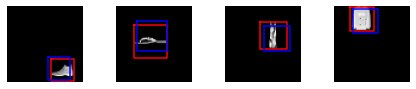

In [ ]:
# Find wrong prediction and display it

model.eval()

count = 0

for i in range(len(dataset2)):
    sample = dataset2[i]
    
    # predict the bounding box for a given image
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
    
    target = sample['bbox'].reshape((1,4))
    iou= IoU(output.cpu().numpy(), target, iou_threshold = 0.7)
    
    if not iou:
        #print(output.cpu().numpy(), target,iou)
        ax = plt.subplot(1, 4, count + 1)
        plt.tight_layout()
        ax.axis('off')
        sample['pred'] = output[0].cpu().numpy()
        show_bbox(**sample)
        count += 1
           
    if count == 4:
        plt.show()
        break

# Exercise 1
Create a CNN model for classification and train it on our synthetic dataset for 5 epochs. For this you must create a new Dataset class that produces the ground truth class labels for classification instead of the bounding box annotations as we did in the `FashionMNISTlocalizationDataset` class.

In [2]:
class FashionMNISTlocalizationDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True)

    def __len__(self): #número de muestras que tiene nuestro dataset
        return self.fashionMnist.data.shape[0]

    def __getitem__(self, idx): #define el comportamiento de devolver una muestra de nuestro dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize) #crear imagen negra de 64x64
        image_width, image_height = self.imgsize
                
        # Get one Fashion-MNIST object, resize it randomly, and copy it into
        # a random location of the black image
        object_img = self.fashionMnist.data[idx,:,:] #seleccionar objeto que toque dado el índice

        object_width  = object_height = np.random.randint(19,47)

        object_img = resize(object_img, (object_height, object_width))

        x_offset = np.random.randint(0,image_width-object_width)
        y_offset = np.random.randint(0,image_height-object_height)

        image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
        
        image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform: #convertir imagen en tensor
            image = self.transform(image)

        # normalize the target values (bounding box coordinates) so they are real numbers from 0. to 1.
        #bbox = np.array([x_offset / image_width, y_offset / image_height, 
                         #object_width / image_width, object_height / image_height], dtype=np.float32)
        
        label = self.fashionMnist.targets[idx] #línea añadida
        sample = {'image': image, 'label': label} #línea añadida

        return sample

In [3]:
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform) #train
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform) #validation

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1), #quedarnos solo con los channels (cargarnos las dimensiones espaciales)
          nn.Flatten(),
          )
        
        self.classifier = nn.Linear(32,10) #línea añadida
        
    def forward(self, x):
        features = self.backbone(x)
        out = self.classifier(features) #línea añadida
        return out #línea añadida

summary(Net(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
Total params: 15,594
Trainable params: 15,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/ba

In [5]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image'] 
        target = sample_batched['label'] #línea añadida
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target) #línea añadida
        loss_values.append(loss)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None: #siempre después del omtimizer.step()
            scheduler.step()
    return loss_values

In [6]:
model = Net().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader)) #modifica el learning rate a lo largo del training de una forma u otra

log_interval = 100 # how many batches to wait before logging training status

classification_loss_history = [] #línea añadida
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch, scheduler)
    classification_loss_history += loss_values #línea añadida

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317518
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.275693
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.010767
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.634559
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.259858
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.094792
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.128453
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.840999
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.027605
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.005924
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.820128
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.757297
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.680589
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.823565
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.813578
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.698050
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.977672
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.897382
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.568781
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.697230
Train Epoch:

# Exercise 2

Plot the training loss curves of the regression model and the classification model in **the same figure**. We want to compare the two loss curves, so it is important to plot them in the same figure and to set up a legend for the plot. This figure is very important because it will give you a hint for the next exercise. 

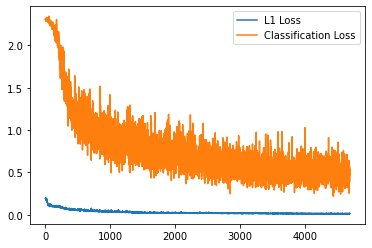

In [19]:
plt.plot(loss_history, label="L1 Loss")
plt.plot(classification_loss_history, label="Classification Loss")
plt.legend()
plt.show()


## HOMEWORK

**A)** With respect to exercise 2. Explain what u observe

- Are both losses equally stable? 
- Which task is harder? Why?

Si una loss es más alta que otra, no significa que la tarea con la loss más alta sea más difícil. En este caso, una loss es cross entropy y otra loss es L1, por lo que son dos problemas distintos. La magnitud de la loss cambia con la fórmula con la que se calcule, por lo que no quiere decir que en este caso Classification sea más difícil.

**B)** Modify the regression model adding a classification output, so that it can jointly predict the bounding box of the object and also its class label. This implies you will need to modify: the model (it must have two separate outputs), the Dataset class (to produce the ground truth class label AND the bounding box coordinates), and your training method by adding a new loss that combines a regression loss and a classification loss. Think about how to combine these two losses in a single cost function to be optimized. 

- Hint: look at the figure of exercise (2). 
- Hint: You should make both losses equally important. 
- Hint: You will need to modify the evaluation function to take into account both correct classification and IoU.

In [21]:
class FashionMNISTlocalizationDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True)

    def __len__(self): #número de muestras que tiene nuestro dataset
        return self.fashionMnist.data.shape[0]

    def __getitem__(self, idx): #define el comportamiento de devolver una muestra de nuestro dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize) #crear imagen negra de 64x64
        image_width, image_height = self.imgsize
                
        # Get one Fashion-MNIST object, resize it randomly, and copy it into
        # a random location of the black image
        object_img = self.fashionMnist.data[idx,:,:] #seleccionar objeto que toque dado el índice

        object_width  = object_height = np.random.randint(19,47)

        object_img = resize(object_img, (object_height, object_width))

        x_offset = np.random.randint(0,image_width-object_width)
        y_offset = np.random.randint(0,image_height-object_height)

        image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
        
        image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform: #convertir imagen en tensor
            image = self.transform(image)

        # normalize the target values (bounding box coordinates) so they are real numbers from 0. to 1.
        bbox = np.array([x_offset / image_width, y_offset / image_height, 
                         object_width / image_width, object_height / image_height], dtype=np.float32)
        label = self.fashionMnist.targets[idx] #línea añadida

        sample = {'image': image, 'label': label, 'bbox':bbox} #línea añadida

        return sample

In [22]:
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform) #train
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform) #validation

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1), #quedarnos solo con los channels (cargarnos las dimensiones espaciales)
          nn.Flatten(),
          )
        
        self.bbox = nn.Sequential(nn.Linear(32,4), nn.Sigmoid()) #línea añadida
        self.classifier = nn.Linear(32,10) #línea añadida
        
    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox(features) #línea añadida
        out = self.classifier(features) #línea añadida
        return out, bbox #línea añadida

summary(Net(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 4]             132
          Sigmoid-12                    [-1, 4]               0
           Linear-13                   [-1, 10]             330
Total params: 15,726
Trainable params: 

In [24]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image'] 
        target1 = sample_batched['label'] #línea añadida
        target2 = sample_batched['bbox'] #línea añadida
        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
        optimizer.zero_grad()
        output1, output2 = model(data)
        loss1 = F.cross_entropy(output1, target1) #línea añadida
        loss2 = F.l1_loss(output2, target2) #línea añadida
        loss = loss1*0.25 + loss2 #le doy solo un 25% de peso a la loss1 (classification)
        loss_values.append(loss)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None: #siempre después del omtimizer.step()
            scheduler.step()
    return loss_values

In [25]:
model = Net().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader)) #modifica el learning rate a lo largo del training de una forma u otra

log_interval = 100 # how many batches to wait before logging training status

loss_history_both = [] #línea añadida

for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch, scheduler)
    loss_history_both += loss_values #línea añadida

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.758611
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.658845
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.655160
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.510657
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.457537
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.374432
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.381482
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.337527
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.241333
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.320213
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.333306
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.266940
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.240160
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.256804
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.314778
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.291420
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.258256
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.239561
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.229442
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.262705
Train Epoch:

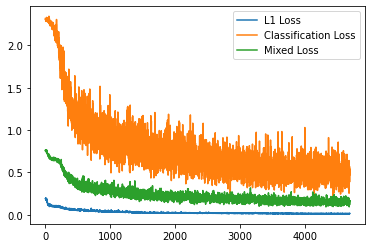

In [26]:
plt.plot(loss_history, label="L1 Loss")
plt.plot(classification_loss_history, label="Classification Loss")
plt.plot(loss_history_both, label="Mixed Loss")

plt.legend()
plt.show()

**C)** Evaluate the trained model for the joint classification and localization task. You must modify the test method to count a given prediction as correct if it correctly localizes the object AND predicts the correct label. Show some mistakes that the model makes and comment on them.

In [32]:
def test(model, device, test_loader):
    model.eval()
    test_loss_gen = 0
    test_loss1 = 0
    test_loss2 = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target1 = sample_batched['label']
            target2 = sample_batched['bbox']
            data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
            output1, output2 = model(data)
            test_loss1 += F.cross_entropy(output1, target1).item()
            test_loss2 += F.l1_loss(output2, target2).item()

            test_loss_gen += (test_loss1*0,25 + test_loss2)
          
            # count the number of prediction with an IoU above a certain threshold
            correct += np.sum(IoU(output.cpu().numpy(), target.cpu().numpy(), iou_threshold = 0.7))

    test_loss_gen /= (len(test_loader.dataset)/test_loader.batch_size)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_gen, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# call the test method
test(model, device, test_loader)

TypeError: ignored

**D)** Modify the model so it can also detect if an input image does not contain any object, show some qualitative results and comment on them. 

- Hint:You will need to modify the dataset class to generate images without objects and its corresponding label (0). This implies shifting all labels by 1.
- Hint: You will need to modify the architecture since we now have 11 outputs (10 classes and a no-object class)
- Hint: You will need to modify the training function to set to regression loss to 0 if the GT class is a no-object class
- Hint: You will need to modify the evaluation function to skip the IoU check if the the predicted class is a no-object class

In [ ]:
# Add your code here